# SMS Spam Classification Project

In this project, we will build a deep learning model to classify SMS messages as spam or ham (non-spam) using a Transformer-enhanced LSTM model. The dataset used for this project is the **SMS Spam Collection Dataset**.

### Step 0: Install Required Libraries
First, we will install the necessary libraries including `kagglehub` for downloading the dataset, `pandas`, `numpy` for data manipulation, `matplotlib`, and `seaborn` for visualizations, and `tensorflow` for model building.


In [ ]:
# Install necessary libraries
!pip install kagglehub pandas numpy matplotlib scikit-learn seaborn keras tensorflow


### Step 1: Import Libraries
Here we import all the required libraries for data loading, processing, model building, and evaluation.


In [ ]:
# Import libraries
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


### Step 2: Download Dataset Using kagglehub
We will download the SMS Spam Collection Dataset using `kagglehub` to make it available for processing.


In [ ]:
# Download dataset using kagglehub
path = kagglehub.dataset_download("uciml/sms-spam-collection-dataset")
print("Path to dataset files:", path)


100%|██████████| 211k/211k [00:00<00:00, 50.8MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/uciml/sms-spam-collection-dataset/versions/1


### Step 3: Load Dataset
Now that the dataset is downloaded, we load the data into a pandas dataframe and rename the columns for clarity. We will also focus only on the `label` and `message` columns.


In [ ]:
# Load dataset
csv_path = f"{path}/spam.csv"  # Adjust path to the downloaded file
df = pd.read_csv(csv_path, encoding="latin-1")  # Adjust encoding as needed
df = df.rename(columns={"v1": "label", "v2": "message"})
df = df[['label', 'message']]  # Drop unused columns


### Step 4: Explore Dataset
Before moving forward, let's take a quick look at the dataset to understand its structure, size, and class distribution.


In [ ]:
# Explore dataset
print("Dataset preview:")
print(df.head())
print("\nDataset size:", len(df))
print("\nClass distribution:")
print(df['label'].value_counts())

# Convert labels to binary format (ham = 0, spam = 1)
df['label'] = df['label'].map({'ham': 0, 'spam': 1})


Dataset preview:
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

Dataset size: 5572

Class distribution:
label
ham     4825
spam     747
Name: count, dtype: int64


### Step 5: Split Dataset
Next, we split the dataset into training, validation, and test sets. We use 70% of the data for training, 15% for validation, and 15% for testing.


In [ ]:
# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(df['message'], df['label'], test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"\nTraining set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")



Training set size: 3900
Validation set size: 836
Test set size: 836


### Step 6: Preprocess Text Data
We preprocess the text data by tokenizing it and padding the sequences to ensure they are of equal length. This will allow the model to process them correctly.


In [ ]:
# Preprocess text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure equal length
max_length = 100
X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_val = pad_sequences(X_val, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)

vocab_size = len(tokenizer.word_index) + 1


### Step 7: Build Transformer-Enhanced Model (Functional API)
Here, we define the deep learning model using the Functional API of Keras. The model includes an embedding layer, a multi-head attention layer, an LSTM layer for sequential modeling, and a dense layer for binary classification.


In [ ]:
# Build Transformer-Enhanced Model (Functional API)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length)(input_layer)
attention_layer = MultiHeadAttention(num_heads=4, key_dim=128)(embedding_layer, embedding_layer)
attention_layer = LayerNormalization()(attention_layer)
lstm_layer = LSTM(64, return_sequences=False)(attention_layer)
dropout_layer = Dropout(0.5)(lstm_layer)
output_layer = Dense(1, activation='sigmoid')(dropout_layer)

# Create the model using the Functional API
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("\nModel Summary:")
model.summary()



Model Summary:


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 100, 128)       │        948,992 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 100, 128)       │        263,808 │ embedding[0][0],       │
│ (MultiHeadAttention)      │                        │                │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 100, 128)       │            256 │ multi_head_attention[… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 64)             │         49,408 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1)              │             65 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,262,529 (4.82 MB)

 Trainable params: 1,262,529 (4.82 MB)

 Non-trainable params: 0 (0.00 B)

### Step 8: Train the Model
Now, we will train the model for 5 epochs using the training data. We will also validate the model using the validation data during training.


In [ ]:
# Train the model
epochs = 5
batch_size = 32

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))


Epoch 1/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 70s 538ms/step - accuracy: 0.8467 - loss: 0.4376 - val_accuracy: 0.9533 - val_loss: 0.1917
Epoch 2/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 68s 427ms/step - accuracy: 0.9726 - loss: 0.1123 - val_accuracy: 0.9856 - val_loss: 0.0587
Epoch 3/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 85s 452ms/step - accuracy: 0.9918 - loss: 0.0322 - val_accuracy: 0.9809 - val_loss: 0.0933
Epoch 4/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 57s 471ms/step - accuracy: 0.9966 - loss: 0.0177 - val_accuracy: 0.9880 - val_loss: 0.0638
Epoch 5/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 77s 430ms/step - accuracy: 0.9985 - loss: 0.0079 - val_accuracy: 0.9892 - val_loss: 0.0684


### Step 9: Plot Accuracy and Loss Graphs
After training, we will plot the accuracy and loss graphs for both the training and validation data to analyze the model's performance over epochs.


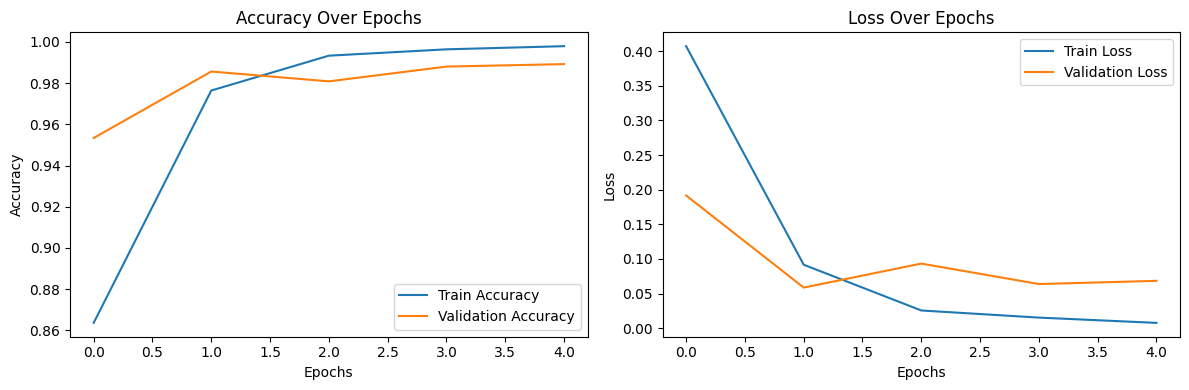

In [ ]:
# Plot Accuracy and Loss Graphs
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### Step 10: Evaluate Model on Test Data
Next, we evaluate the model on the test dataset to check its final accuracy and loss.


In [ ]:
# Evaluate Model on Test Data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.9827 - loss: 0.1016

Test Accuracy: 98.56%
Test Loss: 0.0837


### Step 11: Generate Predictions and Confusion Matrix
We generate predictions using the trained model and plot the confusion matrix to understand the model's classification performance. The confusion matrix will show the number of true positives, true negatives, false positives, and false negatives.


27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step

Confusion Matrix:
 [[723   1]
 [ 11 101]]


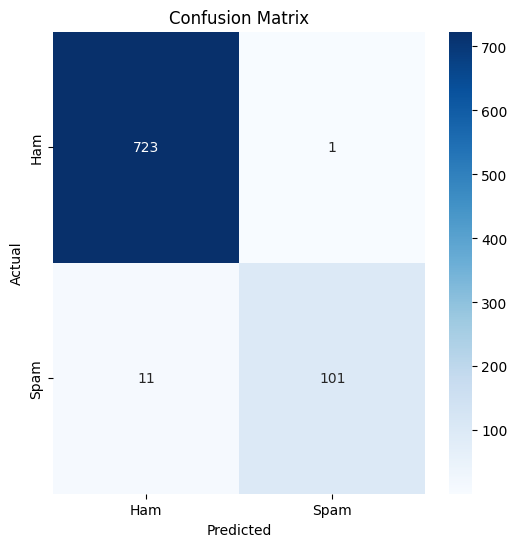


Classification Report:

              precision    recall  f1-score   support

         Ham       0.99      1.00      0.99       724
        Spam       0.99      0.90      0.94       112

    accuracy                           0.99       836
   macro avg       0.99      0.95      0.97       836
weighted avg       0.99      0.99      0.99       836



In [ ]:
# Generate Predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))


### Step 12: Analyze Overfitting
Finally, we analyze whether the model is overfitting. If the training accuracy is much higher than the validation accuracy, or if the validation loss starts increasing after some epochs, it indicates overfitting.


In [ ]:
# Comment: If training accuracy is much higher than validation accuracy, the model might be overfitting.
# Similarly, if validation loss starts increasing after a few epochs, overfitting is indicated.
